<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v12: Near-zero Gradients Explainer
This notebook begins a whole new idea - that I can find direct explanations for computed gradients, and offer explicit explanations for gradients trending towards zero.

Specifically, given sufficient activation, weights, and gradient information surrounding a particular layer at a particular point during training, I can re-execute all of the steps that occurred to calculate the gradients. In so doing, I can break down the steps and identify which set of steps led to zero and near-zero gradients.

In practice I don't have 100% of the information needed, and I also cannot support the same level of flexibility that TF does with its polymorphic layer abstraction. But there's still a lot that can be done, because:
* most layers fall into a very small set of common layers, eg: deep, convolution.
* I can design the "explainer" to degrade gracefully, presenting as much information as it can obtain.

In [76]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
import train_explainer as te
import matmul_explainer as me
from importlib import reload
reload(tot)
reload(te)
reload(me)

HEAD is now at 56eb647 Accurate thresholding in describe_near_zero_explanation()
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 4), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 2.72 KiB | 15.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   56eb647..3088589  main       -> origin/main
Updating 56eb647..3088589
Fast-forward
 Learning_visualisations_v12.ipynb | 236 +++++++++++++++++++++++++++++++++-------------------------
 train_explainer.py                |   2 +-
 2 files changed, 136 insertions(+), 102 deletions(-)


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [47]:
import train_observability_toolkit_test
import train_explainer_test
import matmul_explainer_test
reload(matmul_explainer_test)
reload(train_explainer_test)
reload(train_observability_toolkit_test)
reload(tot)
reload(me)
reload(te)
train_observability_toolkit_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


In [7]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


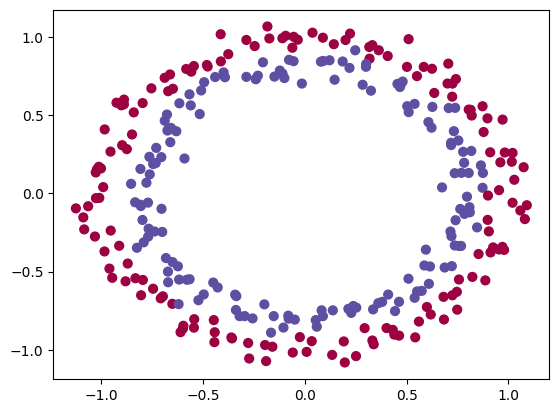

In [8]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [9]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

In [10]:
model.variables

[<KerasVariable shape=(2, 100), dtype=float32, path=sequential_12/dense_84/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_12/dense_84/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_12/dense_85/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_12/dense_85/bias>,
 <KerasVariable shape=(2,), dtype=int64, path=seed_generator_24/seed_generator_state>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_12/dense_86/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_12/dense_86/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_12/dense_87/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_12/dense_87/bias>,
 <KerasVariable shape=(2,), dtype=int64, path=seed_generator_25/seed_generator_state>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_12/dense_88/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_12/dense_88/bias>

## Training with Data collection
The explainer requires that we collect full data for the layer in question and those on either side.
So let's run a training sequence with detailed data collection.

We'll run for a few epochs so that we can pick an iteration that has some interesting characteristics. Also, for this very simple model, we don't have a good idea in advance which layer might lead to some interesting results, and it isn't very big, so we'll just collect all data across all layers.



In [11]:
# This will take a couple of minutes to run
reload(tot)
collection_sets = [{'include_non_trainable': True}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=20, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch     2 - 5.14s/epoch: loss: 0.6832  
Epoch     4 - 1.12s/epoch: loss: 0.6482  
Epoch     6 - 733.44ms/epoch: loss: 0.6094  
Epoch     8 - 667.17ms/epoch: loss: 0.5865  
Epoch    10 - 974.91ms/epoch: loss: 0.5766  
Epoch    12 - 680.98ms/epoch: loss: 0.5409  
Epoch    14 - 665.41ms/epoch: loss: 0.4965  
Epoch    16 - 965.17ms/epoch: loss: 0.4308  
Epoch    18 - 1.27s/epoch: loss: 0.3556  
Epoch    20 - 996.91ms/epoch: loss: 0.2906  
Total training time: 26.56 secs


Now let's take a look at the summary statistics and find a layer of interest and a point in time that's interesting.

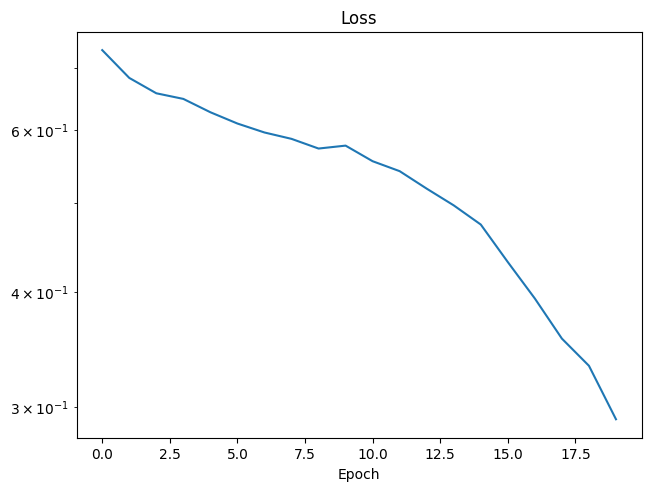

In [12]:
plot_fit(history)

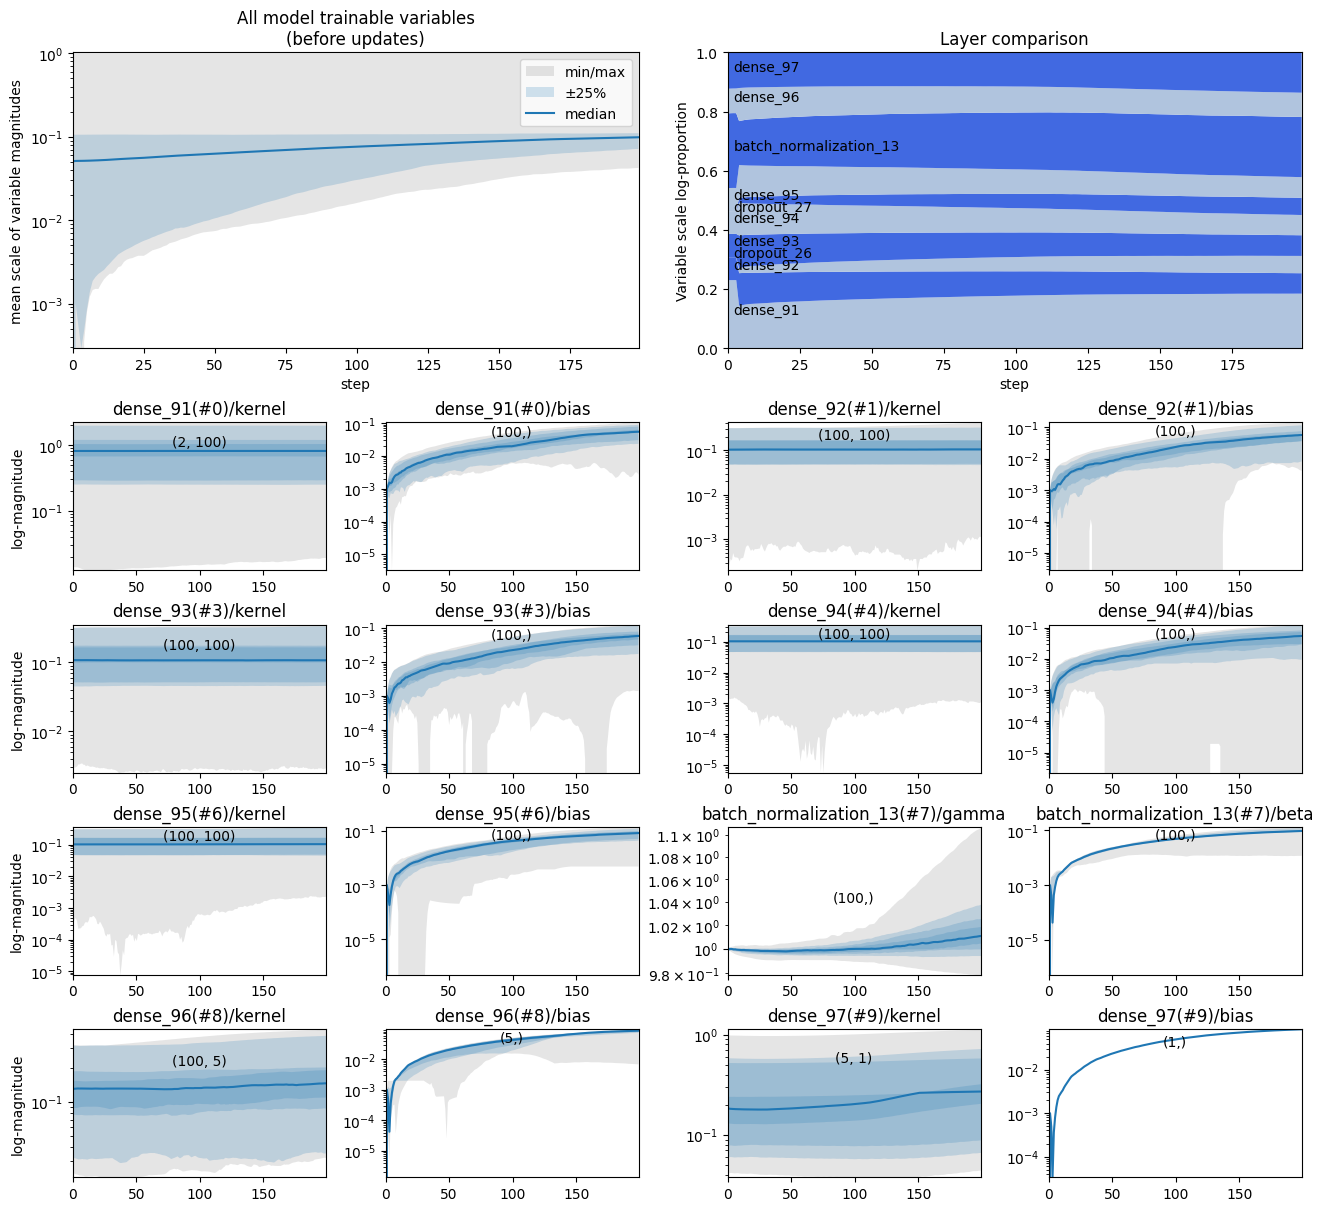

In [13]:
tot.plot_variable_history(variables, magnitudes=True)

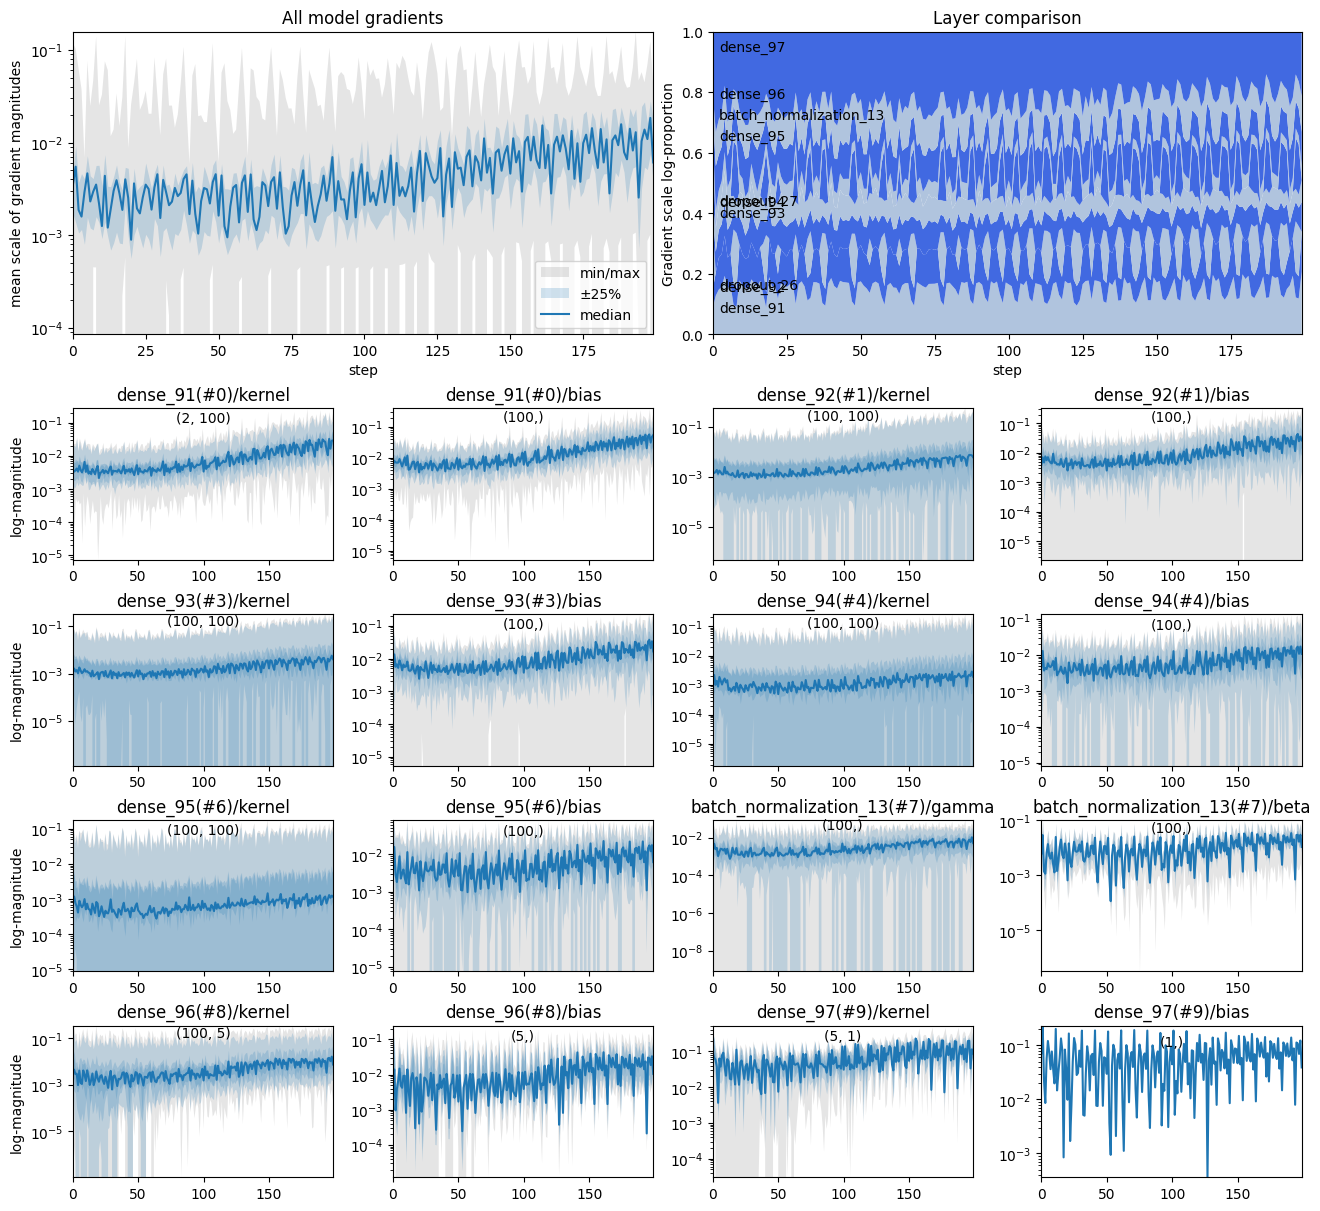

In [14]:
tot.plot_gradient_history(gradients, magnitudes=True)

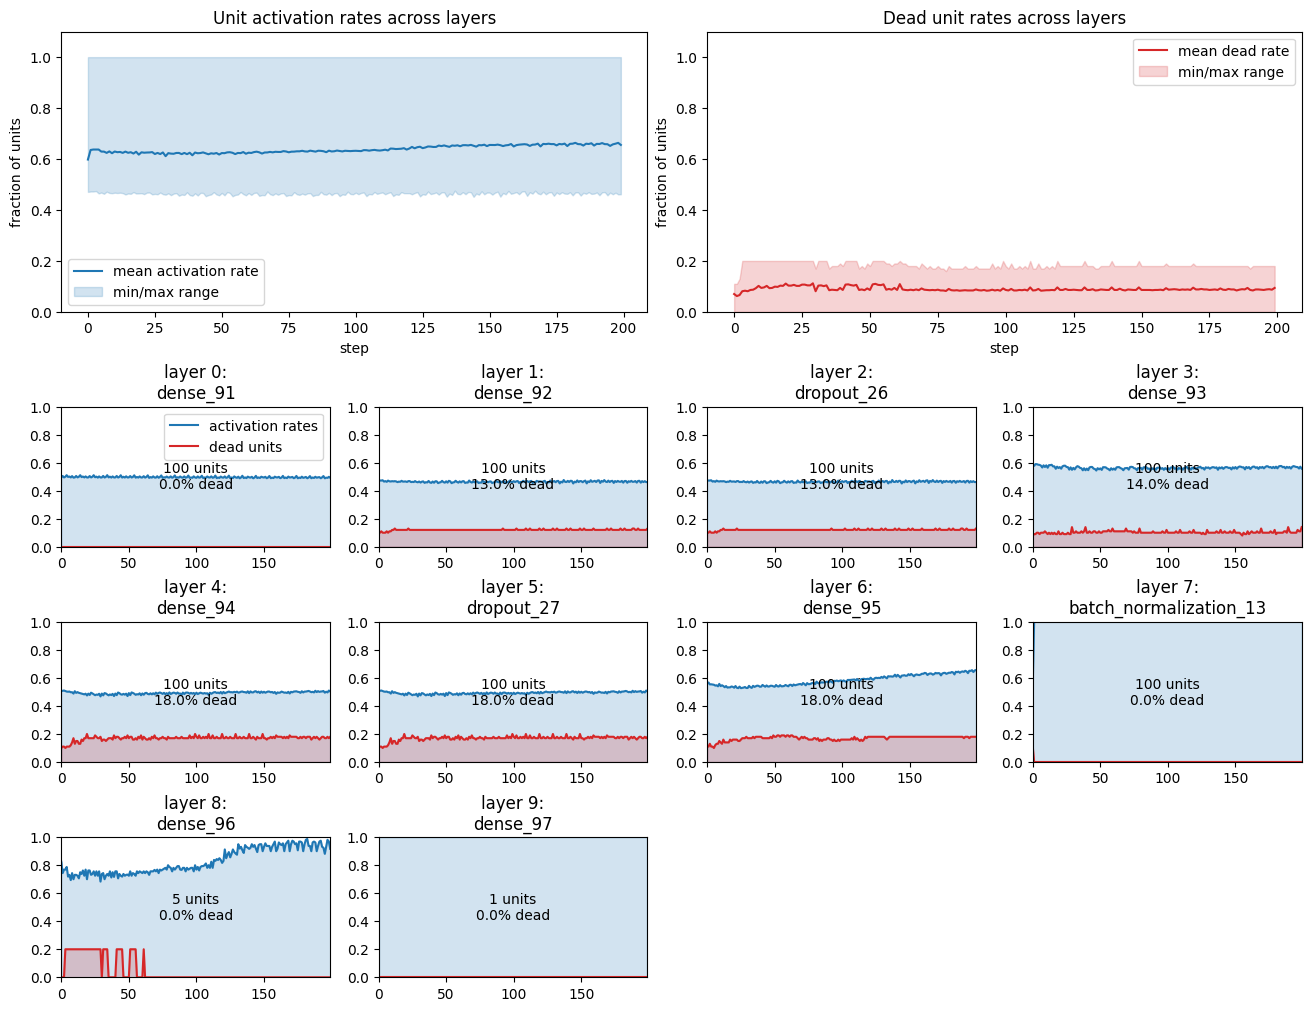

In [15]:
tot.plot_activity_rate_history(activity)

## Point of interest selection
From the above we can conclude that:
* This particular run didn't produce anything very exciting.
* The variable #6 (zero-based), the kernel of layer #4, experienced some zero gradients briefly during its first 200 iterations.

Let's narrow down on an iteration of interest.

In fact, as we'll see, the graphs above are not yet indicating the situation well enough. That variable actually has a large number of its individual values that stay at exactly zero throughout training.

In [16]:
selected_layer_idx = 3
selected_var_idx = 5
selected_iteration = 50
prev_layer_idx = 1
prev_var_idx = 2
next_layer_idx = 4
next_var_idx = 7

In [17]:
print(f"Previous layer: #{prev_layer_idx} = {model.layers[prev_layer_idx].name}, variable: #{prev_var_idx} = {model.variables[prev_var_idx].path}")
print(f"Target layer:   #{selected_layer_idx} = {model.layers[selected_layer_idx].name}, variable: #{selected_var_idx} = {model.variables[selected_var_idx].path}")
print(f"Next layer:     #{next_layer_idx} = {model.layers[next_layer_idx].name}, variable: #{next_var_idx} = {model.variables[next_var_idx].path}")

Previous layer: #1 = dense_92, variable: #2 = sequential_13/dense_92/kernel
Target layer:   #3 = dense_93, variable: #5 = sequential_13/dense_93/kernel
Next layer:     #4 = dense_94, variable: #7 = sequential_13/dense_94/kernel


In [18]:
gradients.gradient_stats[selected_var_idx]

,0.0,12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0
0,-0.038360,-0.003806,-0.001070,-0.000074,0.0,0.000000,0.000659,0.003284,0.037776
1,-0.074615,-0.004208,-0.000673,0.000000,0.0,0.000110,0.001626,0.006200,0.071153
2,-0.053286,-0.004994,-0.001109,0.000000,0.0,0.000007,0.001225,0.004306,0.044780
3,-0.061515,-0.005379,-0.001397,-0.000032,0.0,0.000000,0.001052,0.004522,0.060776
4,-0.036933,-0.002590,-0.000594,0.000000,0.0,0.000085,0.001024,0.003245,0.024244
...,...,...,...,...,...,...,...,...,...
195,-0.132415,-0.006701,-0.000169,0.000000,0.0,0.000617,0.004225,0.015130,0.165644
196,-0.200596,-0.011053,-0.002286,0.000000,0.0,0.000000,0.003237,0.015543,0.288646
197,-0.148109,-0.013547,-0.004100,-0.000317,0.0,0.000000,0.000865,0.006781,0.144308
198,-0.250248,-0.020875,-0.005617,-0.000612,0.0,0.000000,0.000839,0.007331,0.220613


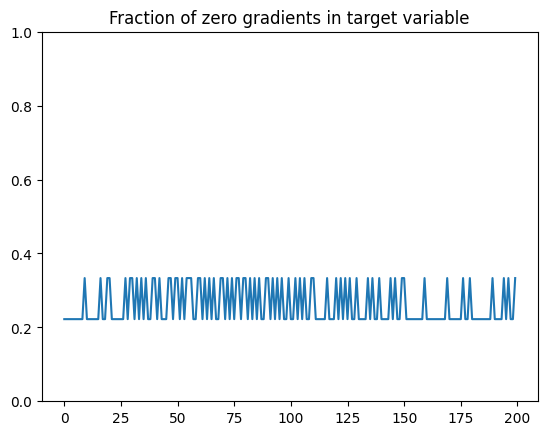

In [19]:
data = gradients.gradient_stats[selected_var_idx].to_numpy()
data = np.sum((data == 0.0), axis=-1) / data.shape[1]

plt.plot(data)
plt.title("Fraction of zero gradients in target variable")
plt.ylim([0.0, 1.0])
plt.show()

Let's take a closer look at the raw values at our selected iteration...

raw_weights: (100, 100)
raw_activations: (32, 100)
raw_gradients: (100, 100)


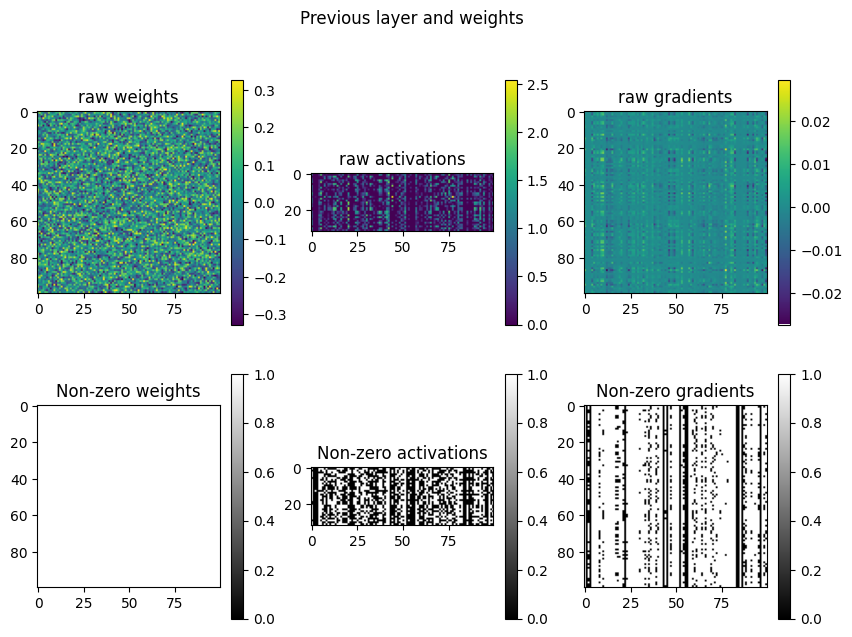

raw_weights: (100, 100)
raw_activations: (32, 100)
raw_gradients: (100, 100)


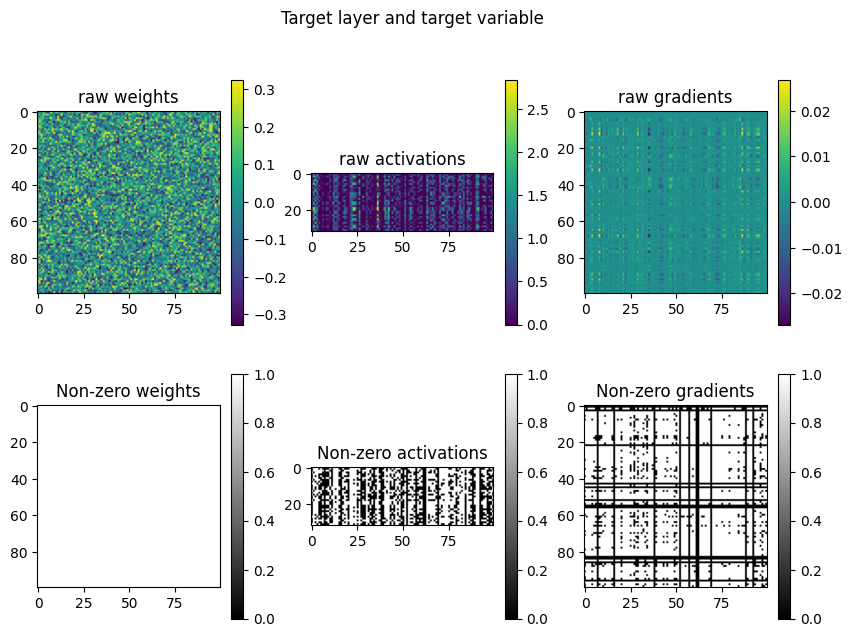

raw_weights: (100, 100)
raw_activations: (32, 100)
raw_gradients: (100, 100)


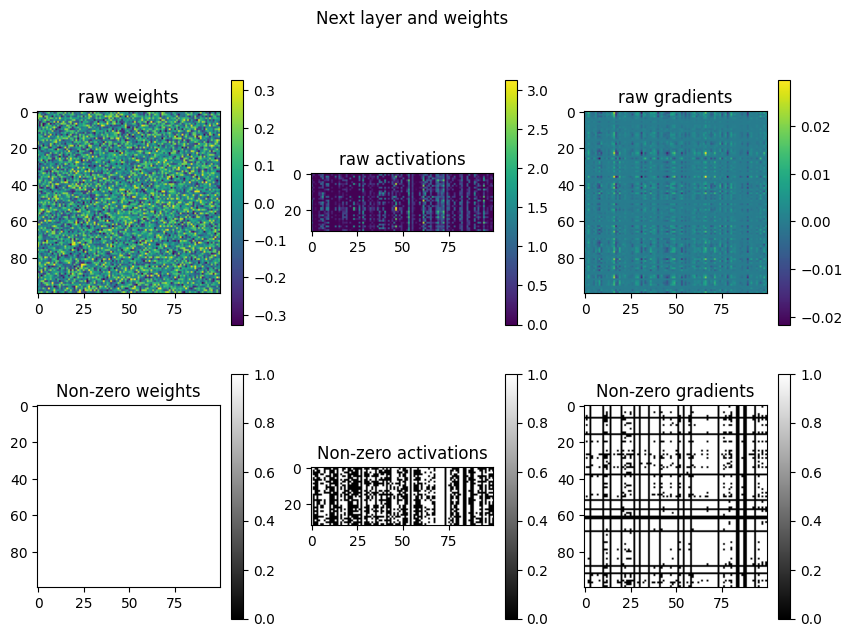

In [20]:
def plot_stuff(title, l_idx, var_idx, it_idx):
  raw_weights = variables.variables[var_idx][it_idx]
  raw_activations = activity.layer_outputs[l_idx][it_idx]
  raw_gradients = gradients.gradients[var_idx][it_idx]
  print(f"raw_weights: {raw_weights.shape}")
  print(f"raw_activations: {raw_activations.shape}")
  print(f"raw_gradients: {raw_gradients.shape}")

  fig = plt.figure(figsize=(10,7))
  fig.suptitle(title)

  plt.subplot(2,3,1)
  plt.title('raw weights')
  plt.imshow(raw_weights)
  plt.colorbar()

  plt.subplot(2,3,2)
  plt.title('raw activations')
  plt.imshow(raw_activations)
  plt.colorbar()

  plt.subplot(2,3,3)
  plt.title('raw gradients')
  plt.imshow(raw_gradients)
  plt.colorbar()

  plt.subplot(2,3,4)
  plt.title('Non-zero weights')
  plt.imshow(raw_weights != 0, cmap='gray', vmin=0.0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,3,5)
  plt.title('Non-zero activations')
  plt.imshow(raw_activations != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.subplot(2,3,6)
  plt.title('Non-zero gradients')
  plt.imshow(raw_gradients != 0, cmap='gray', vmin=0, vmax=1.0)
  plt.colorbar()

  plt.show()

plot_stuff("Previous layer and weights", prev_layer_idx, prev_var_idx, selected_iteration)
plot_stuff("Target layer and target variable", selected_layer_idx, selected_var_idx, selected_iteration)
plot_stuff("Next layer and weights", next_layer_idx, next_var_idx, selected_iteration)


## Explainer implementation

In [59]:
# First, check that we can get terse top-level explanations for near-zero values in tensors and tensor outcomes
grad = gradients.gradients[selected_var_idx][selected_iteration]
W_l = variables.variables[selected_var_idx][selected_iteration]
A_0 = activity.collected_layer_outputs[selected_layer_idx-1][selected_iteration]

print(f"gradients: {te.describe_tensor_near_zero_explanation(me.tensor_classify(grad), verbose=True)}")
print(f"weights:   {te.describe_tensor_near_zero_explanation(me.tensor_classify(W_l), negatives_are_bad=True, verbose=True)}")

print()
res = np.matmul(A_0, W_l)
desc, frac = te.describe_top_near_zero_explanandum(me.matmul_classify(A_0, W_l), input_names=['A_0', 'W_l'])
descriptions, fractions = te.describe_near_zero_explanation(me.matmul_classify(A_0, W_l), input_names=['A_0', 'W_l'])
print(f"Top explanation: {frac * 100:.1f}% due to {desc}")
print(f"All:")
for desc, frac in zip(descriptions, fractions):
  print(f"  {frac * 100:.1f}% due to {desc}")

gradients: 27.6% near-zero
weights:   49.3% negative, 5.0% near-zero

Top explanation: 53.3% due to near-zero values from A_0
All:
  53.3% due to near-zero values from A_0
  55.7% due to near-zero values from either input
  5.0% due to near-zero values from W_l
  2.3% due to positive/negatives from W_l cancelling out (PP ~= PN)
  2.3% due to sums of positive/negatives from both inputs cancelling out (PP+NN ~= NP+PN)


In [80]:
reload(te)
reload(me)
from train_observability_toolkit import _index_by_identity
from train_explainer import _split_by_largest, _find_outbound_layers, _find_inbound_layers, _mask_near_zero, _format_threshold, UnsupportedNetworkError
from train_explainer import describe_top_near_zero_explanandum, describe_near_zero_explanation, describe_tensor_near_zero_explanation

# TODO needs to be extended out to cope with different layer types
def _estimate_backprop_from_layer(model, layer_index, iteration,
                                  gradients: tot.GradientHistoryCallback,
                                  activity: tot.ActivityHistoryCallback,
                                  variables: tot.VariableHistoryCallback):
    print(f"[BEGIN] _estimate_backprop_from_layer(layer_index={layer_index})")

    # get model and identify inbound and outbound layers
    model = gradients.model
    target_layer = model.layers[layer_index]
    inbound_layer_indices = _find_inbound_layers(model, target_layer, return_type='index')
    if not inbound_layer_indices:
        raise UnsupportedNetworkError(f"Layer has no inbound layers")
    if len(inbound_layer_indices) > 1:
        raise UnsupportedNetworkError(f"Layer has multiple inbound layers")
    # print(f"layer: #{layer_index} = {target_layer} at iteration {iteration}")
    # print(f"inbound_layer_indices: {inbound_layer_indices}")

    # pre-compute lookups
    l_to_var_indices = tot.variable_indices_by_layer(model, include_trainable_only=False)
    # print(f"l_to_var_indices: {l_to_var_indices}")

    # get variables, activities, and gradients of interest
    _, _, target_var_idx, target_rest_var_indices = _split_by_largest(target_layer.variables, l_to_var_indices[layer_index])
    if variables.variables[target_var_idx] is None:
        raise UnsupportedNetworkError(
            f"Weights (selected by heuristic) not collected (not trainable?), model.variables index: {target_var_idx}")
    if gradients.gradients[target_var_idx] is None:
        raise UnsupportedNetworkError(
            f"Gradients of weights (selected by heuristic) not collected (not trainable?), model.variables index: {target_var_idx}")
    target_layer_weights = variables.variables[target_var_idx][iteration]
    target_layer_weights_gradients = gradients.gradients[target_var_idx][iteration]
    # print(f"target_layer_weights: {target_layer_weights.shape}")
    # print(f"target_layer_weights_gradients: {target_layer_weights_gradients.shape}")

    # get data of interest from the inbound prev layers
    prev_layers_activations_list = [activity.layer_outputs[l_idx][iteration] for l_idx in inbound_layer_indices]
    # print(f"prev_layers_activations_list: {[a.shape for a in prev_layers_activations_list]}")
    if not prev_layers_activations_list:
        # should never occur
        raise UnsupportedNetworkError(f"No activations from previous layer")
    if len(prev_layers_activations_list) > 1:
        # should never occur
        raise UnsupportedNetworkError(
            f"Multiple activations from previous layer: {[a.shape for a in prev_layers_activations_list]}")

    # estimate backprop from this layer (dJ/dA_0)
    # - let:
    # - we need the backprop gradients that are produced by this layer and which feed into the gradient update step of
    #   the prev layer.
    # - we don't have that, but instead we have the gradients of the weights at this layer, which is one step in
    #   the wrong direction.
    # - we can estimate the backprop gradients as follows:
    #    given:
    #       0 = prev layer, 1 = this layer
    #       dJ/dW_1 = weight gradients at this layer
    #       dZ_1/dW_1 = A_0^T = transposed activations from previous layer
    #       dZ_1/dA_0 = W_1^T = transposed weights from this layer
    #    want:
    #       dJ/dA_0 = backprop gradients to previous layer
    #    #1:
    #       dJ/dW_1 = dZ_1/dW_1 . dJ/dZ_1 = A_0^T . dJ/dZ_1   <-- (f_0 x f_1) = (f_0 x b) . (b x f_1)
    #       => dJ/dZ_1 = (A_0+)^T . dJ/dW_1                   <-- (b x f_1) = (b x f_0) . (f_0 x f_1)
    #    #2:
    #       dJ/dA_0 = dJ/dZ_1 . dZ_1/dA_0 = dJ/dZ_1 . W_1^T   <-- (b x f_0) = (b x f_1) . (f_1 x f_0)
    # TODO do trickery for tensors with spatial dims
    W_1 = target_layer_weights
    dJdW_1 = target_layer_weights_gradients
    A_0 = prev_layers_activations_list[0]
    A_0_inv = tf.linalg.pinv(A_0)
    print(f"dJdW_1: {dJdW_1.shape}, A_0: {A_0.shape}, A_0_inv: {A_0_inv.shape}")
    dJdZ_1 = tf.linalg.matmul(A_0_inv, dJdW_1, transpose_a=True)
    print(f"dJdZ_1: {dJdZ_1.shape}")
    dJdA_0 = tf.linalg.matmul(dJdZ_1, W_1, transpose_b=True)
    print(f"dJdA_0: {dJdA_0.shape}")

    print(f"[END] _estimate_backprop_from_layer()")
    return dJdA_0

###
## The main function
###
def explain_near_zero_gradients(layer_index: int,
                                gradients: tot.GradientHistoryCallback,
                                activity: tot.ActivityHistoryCallback,
                                variables: tot.VariableHistoryCallback,
                                epoch=None, step=None,
                                confidence: float = 0.99,
                                threshold: float = None,
                                verbose=False):
    # get model and identify inbound and outbound layers
    iteration = step if epoch is None else epoch
    model = gradients.model
    target_layer = model.layers[layer_index]
    inbound_layer_indices = _find_inbound_layers(model, target_layer, return_type='index')
    outbound_layer_indices = _find_outbound_layers(model, target_layer, return_type='index')
    if not inbound_layer_indices:
        raise ValueError(f"Layer #{layer_index} has no inbound layers")
    if not outbound_layer_indices:
        raise ValueError(f"Layer #{layer_index} has no outbound layers")
    print(f"layer: #{layer_index} = {target_layer} at iteration {iteration}")
    print(f"inbound_layer_indices: {inbound_layer_indices}")
    print(f"outbound_layer_indices: {outbound_layer_indices}")

    # pre-compute lookups
    l_to_var_indices = tot.variable_indices_by_layer(model, include_trainable_only=False)
    l_train_to_var_indices = tot.variable_indices_by_layer(model, include_trainable_only=True)
    print(f"l_to_var_indices: {l_to_var_indices}")

    # get variables, activities, and gradients of interest
    # - identify the weights via heuristic: the largest variable
    # - note: if largest variable isn't trainable, then we won't get gradients for it
    _, _, target_var_idx, target_rest_var_indices = _split_by_largest(target_layer.variables,
                                                                      l_to_var_indices[layer_index])
    target_layer_weights = variables.variables[target_var_idx][iteration]
    target_layer_activations = activity.layer_outputs[layer_index][iteration]
    target_layer_gradients = gradients.gradients[target_var_idx][iteration]
    print(f"target_layer_weights: {target_layer_weights.shape}, target_rest_var_indices: {target_rest_var_indices}")
    print(f"target_layer_activations: {target_layer_activations.shape}")
    print(f"target_layer_gradients: {target_layer_gradients.shape}")

    # get data of interest from the inbound prev layers
    prev_layers_activations_list = [activity.layer_outputs[l_idx][iteration] for l_idx in inbound_layer_indices]
    print(f"prev_layers_activations_list: {[a.shape for a in prev_layers_activations_list]}")

    # get data of interest from the outbound next layers
    next_layer_weights, _ = _split_by_largest(variables.variables[v_idx][iteration] for v_idx in
                                              l_to_var_indices[outbound_layer_indices[0]])  # just a dodgy hack for now
    next_layers_gradients_lists = [[gradients.gradients[v_idx][iteration] for v_idx in l_to_var_indices[l_idx]] for
                                   l_idx in outbound_layer_indices]  # nested list of list of gradients
    next_layers_weights_grad_list = [_split_by_largest(gradients_list)[0] for gradients_list in
                                     next_layers_gradients_lists]  # gradients of just the main weights
    print(f"next_layer_weights: {next_layer_weights.shape}")
    print(f"next_layers_gradients_list: {[[w.shape for w in lst] for lst in next_layers_gradients_lists]}")
    print(f"next_layers_weights_grad_list: {[w.shape for w in next_layers_weights_grad_list]}")

    # identify near-zero points of interest
    near_zero_gradients_mask, near_zero_gradients_threshold = _mask_near_zero(target_layer_gradients, confidence,
                                                                              threshold, return_threshold=True)
    num_near_zero_gradients = np.sum(near_zero_gradients_mask)
    num_gradients = np.size(target_layer_gradients)

    # estimate forward pass - Z_l
    # TODO move into a handler class and handle different layer types
    # TODO may be able to sometimes hack the layer, strip off its activation function, and use it directly
    # TODO don't be so naive to assume that the first of the rest is the bias.
    W_l = target_layer_weights
    Z_l = None
    if len(prev_layers_activations_list) == 0:
        print(f"WARN: Unable to infer pre-activation outputs: no activations from previous layer")
    elif len(prev_layers_activations_list) > 1:
        print(
            f"WARN: Unable to infer pre-activation outputs: multiple activations from previous layer: {[a.shape for a in prev_layers_activations_list]}")
    else:
        A_0 = prev_layers_activations_list[0]
        b_l = variables.variables[target_rest_var_indices[0]][iteration]
        Z_l = np.matmul(A_0, W_l) + b_l

    # TODO if we're confident in our estimate of Z_l, we can more accurately calculate S_l without having to assume ReLU
    # estimate forward pass - activation function gradients (S_l)
    A_l = target_layer_activations
    S_l_note = None
    if Z_l is None:
        # estimate S_l from A_l, assuming ReLU
        # - original S_l = {1 if Z_l[ij] >= 0 else 0}
        # - even assuming ReLU, we cannot identify Z_l[ij] < 0 vs Z_l[ij] = 0
        # - so we assume A_l[ij] == 0 => Z_[ij] < 0, thus:
        # - estimated S_l = {1 if A_l[ij] > 0 else 0}
        S_l = tf.cast(A_l > 0, tf.float32)
        S_l_note = "estimated S_l value from A_l, assuming ReLU"
    else:
        # calculate accurate S_l from Z_l
        #   A_l = Z_l (.) S_l   -- element-wise
        # so:
        #   S_l = A_l / Z_l or assume 0.0 if A_l is zero (eg: compatible with sigmoid)
        S_l = np.divide(A_l, Z_l, out=np.zeros_like(A_l), where=(Z_l > 0))

    # estimate backprop pass - backprop from next layer (dJ/dA_l)
    next_layers_backprop_gradients_list = []
    for l_idx in outbound_layer_indices:
        backprop = None
        try:
            backprop = _estimate_backprop_from_layer(model, l_idx, iteration, gradients, activity, variables)
        except UnsupportedNetworkError as e:
            print(f"WARN: Unable to infer backprop from next layer #{l_idx}: {e.message}")
        next_layers_backprop_gradients_list.append(backprop)
    print(f"next_layers_backprop_gradients_list: {[bp.shape for bp in next_layers_backprop_gradients_list]}")

    def _explain_tensor(name, tensor, mask_name=None, mask=None, negatives_are_bad=False):
        quantiles = [0, 25, 50, 75, 100]
        counts, sums, threshold = me.tensor_classify(tensor, confidence=confidence, return_threshold=True)
        print(f"{name}:")
        print(f"  shape:             {np.shape(tensor)} -> total values: {np.size(tensor)}")
        print(f"  summary:           {describe_tensor_near_zero_explanation(counts, sums, threshold=threshold, negatives_are_bad=negatives_are_bad, verbose=verbose)}")
        if verbose:
            print(f"  value percentiles: {quantiles} -> {tfp.stats.percentile(tensor, quantiles).numpy()}")
            print(f"  PZN counts/sums:   {me.summarise(counts, sums, show_percentages=False, show_means=False)}")
            print(f"  PZN counts/means:  {me.summarise(counts, sums, show_percentages=True, show_means=True)}")
        if mask_name:
            print(f"  {(mask_name + ':'):19} {describe_tensor_near_zero_explanation(counts, sums, mask=mask, threshold=threshold, negatives_are_bad=negatives_are_bad, verbose=verbose)}")
        if mask_name and verbose:
            print(f"  {(mask_name + ':'):19} {me.summarise(counts, sums, mask=mask, show_percentages=True, show_means=True)}")

    def _explain_combination(name, inputs, result, counts, sums, fixed_threshold=None):
        # note: has noteworthy level of zeros if exceed 1.1x the percent we'd expect from the confidence level alone.
        # That gives a little leeway for rounding errors.
        print(f"compute {name}:")
        print(f"  inputs examined:   {', '.join(inputs)}")
        mask, threshold = _mask_near_zero(result, confidence=confidence, fixed_threshold=fixed_threshold,
                                          return_threshold=True)
        orig_total = np.size(counts[..., 0])
        mask_total = np.sum(mask)
        fraction = mask_total / orig_total
        noteworthy = fraction > (1.1 * (1 - confidence))
        if noteworthy:
            top_description, top_fraction = describe_top_near_zero_explanandum(counts, sums, input_names=inputs, mask=mask, threshold=threshold)
            print(f"  summary:           {fraction * 100:.1f}% near-zero, of which {top_fraction * 100:.1f}% are affected by {top_description}")
        else:
            print(f"  summary:           {fraction * 100:.1f}% near-zero")
        if verbose:
            print(f"  PZN combinations:  {me.summarise(counts, sums, show_percentages=False, show_means=False)}")
            print(f"  PZN combinations:  {me.summarise(counts, sums, show_percentages=True, show_means=True)}")

    def _explain_combination_near_zero(name, inputs, result, counts, sums, fixed_threshold=None):
        if not verbose:
            return  # skip whole section if not in verbose mode
        mask, threshold = _mask_near_zero(result, confidence=confidence, fixed_threshold=fixed_threshold,
                                          return_threshold=True)
        orig_total = np.size(counts[..., 0])
        mask_total = np.sum(mask)
        print(f"{name} {mask_total / orig_total * 100:.1f}% near zero ({_format_threshold(threshold)}):")
        print(f"  PZN combinations:  {me.summarise(counts, sums, mask=mask, show_percentages=False, show_means=False)}")
        print(f"  PZN combinations:  {me.summarise(counts, sums, mask=mask, show_percentages=True, show_means=True)}")

        # preferred detail - list of causal explanandums
        descriptions, fractions = te.describe_near_zero_explanation(counts, sums, input_names=inputs, mask=mask, threshold=threshold)
        if descriptions:
            for description, fraction in zip(descriptions, fractions):
                print(f"  {fraction*100:.1f}% affected by {description}")

        # fall-back detailed description - filtered and grouped classifications
        # (less visually pleasing, so only using as fallback)
        if not descriptions:
            counts, sums, terms = me.filter_classifications(counts, sums)
            count_groups, sum_groups, term_groups = me.group_classifications(counts, sums, terms, mask=mask)
            count_groups, sum_groups, term_groups, coverage = me.filter_groups(
                count_groups, sum_groups, term_groups, completeness=0.75, max_groups=10, return_coverage=True)
            desc = me.describe_groups(count_groups, sum_groups, term_groups, show_ranges=True)
            for size, summary in zip(desc['sizes'], desc['summaries']):
                print(f"  {size / mask_total * 100:.1f}% explained as (counts/sums): {summary}")
            print(f"  (explains top most {coverage * 100:.1f}% of near-zero)")

    # explain context
    print()
    print(f"Summary...")
    print(f"  near-zero gradients: {num_near_zero_gradients} ({num_near_zero_gradients / num_gradients * 100:0.1f}%) {_format_threshold(near_zero_gradients_threshold)}")

    print()
    print("Let:")
    print("  A_0 <- input activation to target layer")
    print("  W_l <- weights of target layer")
    print("  Z_l <- pre-activation output of target layer")
    print("  S_l <- effect of activation function as element-wise multiplier")
    print("  A_l <- output activation of target layer")
    if verbose:
        print("  PZN <- breakdown of values into (P)ositive, near-(Z)ero, or (N)egative")

    # explain forward pass
    # - let A_0 be input activation to this layer (not necessarily the first layer input)
    print()
    print(f"Forward pass...")
    for idx, activations in enumerate(prev_layers_activations_list):
        name = "A_0" if len(prev_layers_activations_list) == 1 else f"A_0#{idx}"
        A_0 = activations
        _explain_tensor(name + ' - input value', A_0)
    _explain_tensor("W_l - weights of target layer", W_l, "corresponding to near-zero gradients",
                    near_zero_gradients_mask)
    if Z_l is None:
        print(f"Z_l = A_0 . W_l + b_l:")
        print(f"  Unable to infer")
    else:
        counts, sums = me.matmul_classify(A_0, W_l, confidence=confidence)
        _explain_combination("Z_l = A_0 . W_l + b_l", ['A_0', 'W_l'], Z_l, counts, sums)
        _explain_combination_near_zero("Z_l", ['A_0', 'W_l'], Z_l, counts, sums)
        _explain_tensor("Z_l - pre-activation output", Z_l, negatives_are_bad=True)
    _explain_tensor("S_l - activation function", S_l)
    if S_l_note and verbose:
      print(f"  note:              {S_l_note}")
    _explain_tensor("A_l - activation output from target layer", A_l)

    # explain backprop pass
    # - starts with dJdA_l
    # - compute dJ/dZ_l = dJ/dA_l x S_l (element-wise)
    # - compute dJ/dW_l = A_0^T . dJ/dZ_l    <-- note: experimentally this produces very accurate results.
    print()
    print(f"Backward pass...")
    for dJdA_l in next_layers_backprop_gradients_list:
        dJdZ_l = np.multiply(dJdA_l, S_l)
        counts, sums = me.multiply_classify(dJdA_l, S_l, confidence=confidence)
        _explain_combination("dJ/dZ_l = dJ/dA_l x S_l (element-wise)", ['dJ/dA_l', 'S_l'], dJdZ_l, counts, sums)
        print(f"  note:              using estimated dJ/dA_l value")
        _explain_combination_near_zero("dJdZ_l", ['dJ/dA_l', 'S_l'], dJdZ_l, counts, sums)
        _explain_tensor("dJ/dZ_l", dJdZ_l)
    for dJdA_l in next_layers_backprop_gradients_list:
        A_0t = tf.transpose(A_0)
        dJdZ_l = np.multiply(dJdA_l, S_l)  # redoing from above
        dJdW_l = np.matmul(A_0t, dJdZ_l)
        counts, sums = me.matmul_classify(A_0t, dJdZ_l, confidence=confidence)
        _explain_combination("dJ/dW_l = A_0^T . dJ/dZ_l", ['A_0^T', 'dJ/dZ_l'], target_layer_gradients, counts, sums,
                             threshold)
        _explain_combination_near_zero("dJdW_l", ['A_0^T', 'dJ/dZ_l'], target_layer_gradients, counts, sums, threshold)
    _explain_tensor("actual dJdW_l", target_layer_gradients)


explain_near_zero_gradients(selected_layer_idx, gradients, activity, variables, step=selected_iteration, verbose=True)

layer: #3 = <Dense name=dense_93, built=True> at iteration 50
inbound_layer_indices: [2]
outbound_layer_indices: [4]
l_to_var_indices: [[0, 1], [2, 3], [4], [5, 6], [7, 8], [9], [10, 11], [12, 13, 14, 15], [16, 17], [18, 19]]
target_layer_weights: (100, 100), target_rest_var_indices: [6]
target_layer_activations: (32, 100)
target_layer_gradients: (100, 100)
prev_layers_activations_list: [TensorShape([32, 100])]
next_layer_weights: (100, 100)
next_layers_gradients_list: [[TensorShape([100, 100]), TensorShape([100])]]
next_layers_weights_grad_list: [TensorShape([100, 100])]
[BEGIN] _estimate_backprop_from_layer(layer_index=4)
dJdW_1: (100, 100), A_0: (32, 100), A_0_inv: (100, 32)
dJdZ_1: (32, 100)
dJdA_0: (32, 100)
[END] _estimate_backprop_from_layer()
next_layers_backprop_gradients_list: [TensorShape([32, 100])]

Summary...
  near-zero gradients: 2760 (27.6%) = 0

Let:
  A_0 <- input activation to target layer
  W_l <- weights of target layer
  Z_l <- pre-activation output of target lay

In [31]:
l = [1, 2, 3, 4]
l[(0,1)]

TypeError: list indices must be integers or slices, not tuple

In [19]:
t = "hello"
f"{t:20}"

'hello               '

In [20]:
a = tf.random.normal((5,5))
a
tfp.stats.percentile(tf.abs(a), 1.).numpy()

0.025829127

## Next steps:
* ~Add masking to focus on just those gradient values that are near-zero.
Specifically:~
    1. ~identify a mask against dJ/dW_l~
    2. ~when looking at W_l, provide global PZN results, but also provide summary stats across just those that are marked~
    3. ~figure out how to do that for Z_l, A_l, and S_l -- hint: there is where stats over the stats come into play~
    4. ~figure out how to apply that for the backward pass~

* ~Also, double check my estimate of dJdW_l vs the actual collected dJdW_l. And regardless, I should report on the stats from the actual dJdW_l, rather than my estimate.~

* ~Use describe_top_near_zero_explanandums() to get a list of the top-5-ish best explanandums (in order) and list all of those when verbose mode. And fallback on raw me.summarise(..., mask=mask) output to cover off the individual explanations by single components.~
* ~Accurately infer S_l~
* Handle variations in input/output layer counts
* Handle variations in layer types

In [21]:
a = tf.constant([
    [0.5, -0.5, -0.2, 1, 0.00]
])
tf.logical_and((a > 0), tf.logical_not(a == 0))

<tf.Tensor: shape=(1, 5), dtype=bool, numpy=array([[ True, False, False,  True, False]])>

In [22]:
f = 'a'
len(f)

1

In [23]:
def _split_by_largest(tensors):
    """
    Splits the given list of tensors into the single largest tensor, and the rest.
    Useful as a heuristic for identifying the main weights tensor in a layer and the rest, without assuming
    a particular order.
    If there are multiple largest tensors, the first one is returned.
    Returns:
      largest_tensor, [rest]
    """
    biggest_t, biggest_idx = None, None
    for t_idx, t in enumerate(tensors):
        if t is not None:
            if biggest_t is None or tf.size(t) > tf.size(biggest_t):
                biggest_t = t
                biggest_idx = t_idx
    rest = [t for t_idx, t in enumerate(tensors) if t_idx != biggest_idx]
    return biggest_t, rest

g1 = gradients.gradients[7][5]
g2 = gradients.gradients[8][5]
print(f"g1: {g1.shape}, g2: {g2.shape}")
_split_by_largest([g1, g2])[0]

g1: (100, 100), g2: (100,)


<tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[ 0.00000000e+00, -1.13426388e-04,  5.42557507e-04, ...,
        -8.13623017e-04,  0.00000000e+00, -1.33627700e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.26294209e-05,  5.36101288e-04, ...,
        -3.86613188e-04,  0.00000000e+00, -3.02332162e-04],
       ...,
       [-1.05683354e-03,  8.21449049e-03,  1.56821765e-03, ...,
         2.98474845e-03,  0.00000000e+00,  4.35796101e-03],
       [ 1.08741464e-04,  6.11560885e-04, -3.80127458e-04, ...,
        -3.63224943e-04,  0.00000000e+00,  2.06879398e-04],
       [ 0.00000000e+00, -1.41131328e-04, -5.60606248e-04, ...,
        -1.54072783e-04,  0.00000000e+00, -5.16355358e-05]], dtype=float32)>

## Appendix: Understanding the model graph structure

In [ ]:
model.summary()


In [ ]:
def find_layer_by_node(model, node, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  if return_type not in ['layer', 'index']:
    raise ValueError(f"return_type must be one of 'layer', 'index', got: {return_type}")
  for l_idx, layer in enumerate(model.layers):
    if node in layer._inbound_nodes:
      return layer if return_type == 'layer' else l_idx
  return None

def find_inbound_layers(model, layer, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  layers = [find_layer_by_node(model, node, return_type) for inbound in layer._inbound_nodes for node in inbound.parent_nodes]
  return [node for node in layers if node != None]

def find_outbound_layers(model, layer, return_type='layer'):
  """
  :return_type: one of 'layer', 'index'
  """
  layers = [find_layer_by_node(model, node, return_type) for node in layer._outbound_nodes]
  return [node for node in layers if node != None]


for l_idx in range(len(model.layers)):
  layer = model.layers[l_idx]
  print(f"Reference layer #{l_idx}: {layer}")
  print(f"  Inbound: {find_inbound_layers(model, layer, 'index')} = {find_inbound_layers(model, layer)}")
  print(f"  Outbound: {find_outbound_layers(model, layer, 'index')} = {find_outbound_layers(model, layer)}")




In [ ]:
model.layers[0]._inbound_nodes[0].parent_nodes

In [ ]:
model.layers[1].summary()

In [ ]:
for l_idx, layer in enumerate(model.layers):
  print(f"layer #{l_idx}: {layer.name}")
  print(f"  ")

In [ ]:
model.layers[1]

In [ ]:
model.layers[1]._inbound_nodes

In [ ]:
model.layers[1]._inbound_nodes[0].parent_nodes

In [ ]:
model.layers[1]._inbound_nodes[0].parent_nodes[0].parent_nodes

In [ ]:
model.layers[1]._outbound_nodes

In [ ]:
model.layers[1]._outbound_nodes[0].outputs

In [ ]:
model.layers[1]._outbound_nodes[0].layer